In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer         
from gensim.models import Word2Vec   
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


from numba import jit, cuda


from transformers import AutoModelForSequenceClassification


/home/thabsheerjm/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "./Data/Reviews.csv"
df = pd.read_csv(path)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df.shape

(568454, 11)

In [10]:
dict = {}
for i in range(1,6):
    dict[i] = 0
for i in df['Score']:
    dict[i] +=1
print(dict)




{1: 52268, 2: 29769, 3: 42640, 4: 80655, 5: 363122}


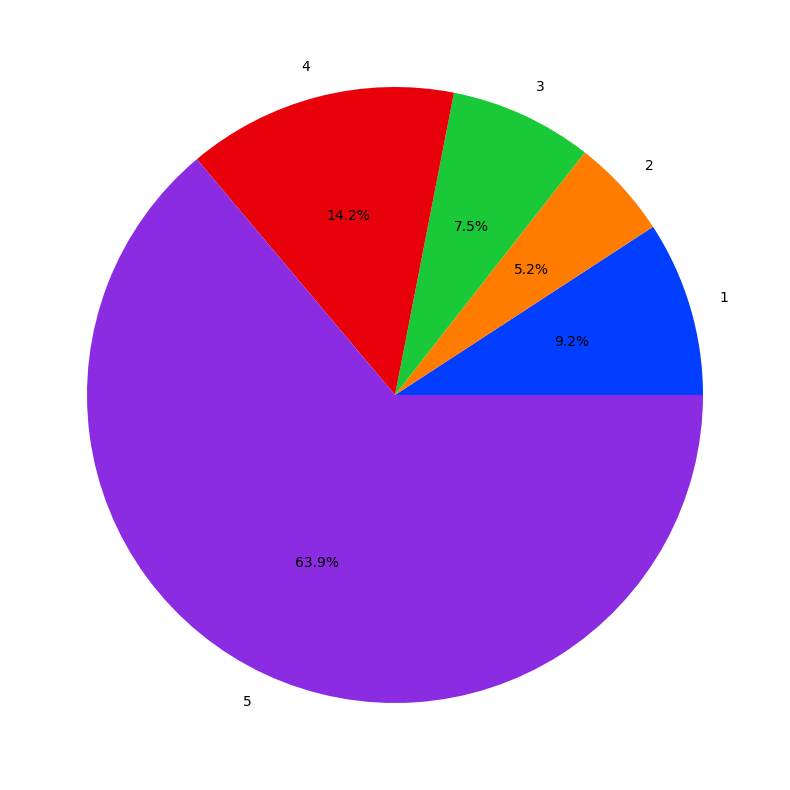

In [11]:
data = []
labels = []
keys = list(dict.keys())
for i in range(1,6):
    data.append(dict[i])
    labels.append(keys[i-1])

colors = sns.color_palette('bright')[0:5]
plt.figure(figsize=(10,10))
plt.pie(data,labels=labels,colors=colors,autopct='%1.1f%%')
# plt.title("Score distribution")
plt.show()

In [12]:
df.isnull().sum()
# we are interested in text and Score, check if there is any null point in those

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
is_duplicated              0
dtype: int64

In [13]:
df['is_duplicated'] = df.duplicated()
df[df["is_duplicated"] == True].count()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
is_duplicated             0
dtype: int64

In [14]:
for ct,i in enumerate(df['Score']):
    if i >3:
        df.Score[ct] = 'Positive'
    elif i<3:
        df.Score[ct] = 'Negative'
    else:
        df.Score[ct] = 'Neutral'



/tmp/ipykernel_11187/4216725595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Score[ct] = 'Positive'


In [15]:

data = df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Time','Summary','is_duplicated'],axis=1)
rnm_dict = {'Score':'Sentiment', 'Text':'Text'}
data.rename(columns=rnm_dict, inplace=True)
data.head()


,Sentiment,Text
0,Positive,I have bought several of the Vitality canned d...
1,Negative,Product arrived labeled as Jumbo Salted Peanut...
2,Positive,This is a confection that has been around a fe...
3,Negative,If you are looking for the secret ingredient i...
4,Positive,Great taffy at a great price. There was a wid...


In [16]:
data.shape

(568454, 2)

In [17]:
# drop neutral, classify as either positive or negative review
neutral = data[data['Sentiment']=='Neutral']
index_of_neutral =neutral.index
data.drop(index_of_neutral, inplace=True)
Data = data.copy()  # For part 2


In [18]:
print(data[data['Sentiment']== 'Neutral'])

Empty DataFrame
Columns: [Sentiment, Text]
Index: []


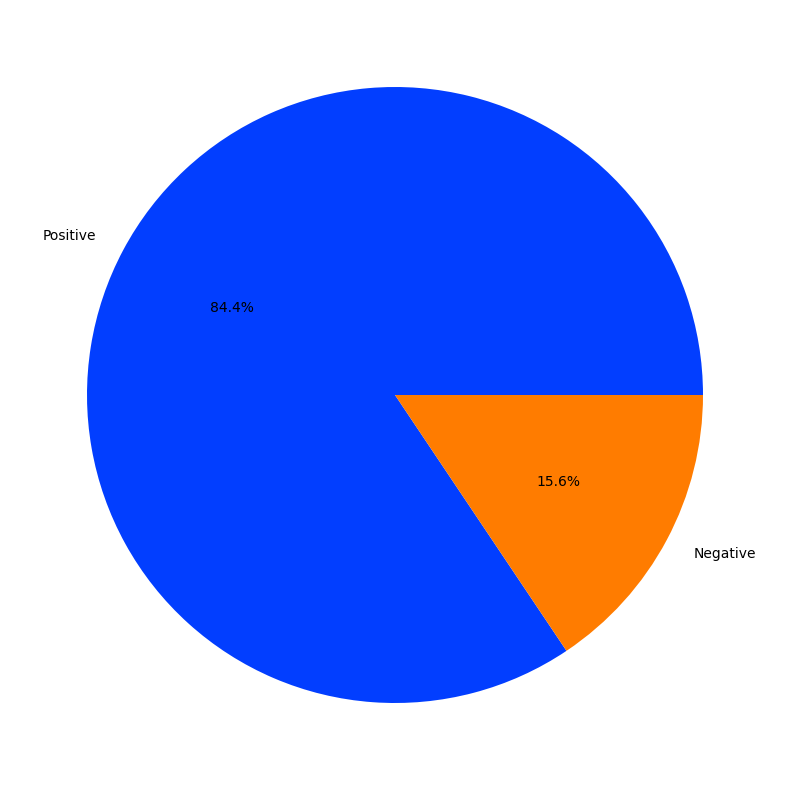

In [19]:

X_data = data.Text
Y_data = data.Sentiment

P=0
N=0
for i in Y_data:
    if i == 'Positive':
        P +=1
    elif i =='Negative':
        N +=1
colors = sns.color_palette('bright')[0:2]
plt.figure(figsize=(10,10))
plt.pie(x = [P,N],labels=['Positive','Negative'],colors=colors,autopct='%1.1f%%')
plt.show()



In [20]:
print(X_data)

0         I have bought several of the Vitality canned d...
1         Product arrived labeled as Jumbo Salted Peanut...
2         This is a confection that has been around a fe...
3         If you are looking for the secret ingredient i...
4         Great taffy at a great price.  There was a wid...
                                ...                        
568449    Great for sesame chicken..this is a good if no...
568450    I'm disappointed with the flavor. The chocolat...
568451    These stars are small, so you can give 10-15 o...
568452    These are the BEST treats for training and rew...
568453    I am very satisfied ,product is as advertised,...
Name: Text, Length: 525814, dtype: object


In [22]:
# Stop word removal
stop_words = set(stopwords.words('english'))
print(stop_words)

{'me', "should've", "don't", 'both', 're', "it's", 'down', 'haven', 'into', 'has', 'did', 'of', 's', 'y', 'doing', 'those', 'after', 'didn', 'he', 'all', "hadn't", "you've", 'they', 'under', 'each', "shouldn't", 'isn', 'between', 'yours', "you're", 'too', 'further', 'these', 'them', 'his', 'is', "she's", 'don', 'now', "shan't", 'to', 'am', 'how', 'm', 'about', 'ourselves', 'which', 'as', 'no', 'been', 'can', 'own', 'very', 'up', "didn't", 'll', 'most', 'there', 'at', 'out', 'myself', 'yourself', 'had', 'be', 'over', 'our', "needn't", 'until', 'couldn', "doesn't", 'ma', 'yourselves', 'this', "couldn't", 'who', 'whom', 'does', 'and', 'few', 'against', 'or', 'it', 'aren', 'my', 'that', 'will', "hasn't", 'her', 'so', 'during', 'why', 'its', 'd', 'him', 'theirs', 'an', 'from', 'hadn', 'nor', 'wouldn', 'than', 'with', 'shan', 'herself', 'because', 'are', "wasn't", 'here', 'some', 'itself', 'you', 'was', 'any', "mightn't", 'wasn', 'then', 'for', "won't", 'only', "isn't", 'themselves', 'have',

In [23]:
def cleanse(X):
    stop_words = set(stopwords.words('english'))
    tx = []
    tmp = []
    stemmer = nltk.stem.SnowballStemmer('english')
    for text in X:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ',text)
        text = re.sub('\[[^]]*\]', ' ',text) 
        text = re.sub(r'http\S+', ' ',text)
        text = re.sub(r'[?|!|\'|"|#]',r'',text)
        text = re.sub(r'[.|,|)|(|\|/]',r' ',text)  
        words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
        tx.append(words)
    for text in tx:
        tmp.append(' '.join(text))
    return tmp

In [24]:
X_data = cleanse(X_data)

In [25]:
X_data[0]

'bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better'

In [26]:
#Split the dataset

X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,train_size=0.7,stratify=Y_data, random_state=19)


In [27]:
# TF-IDF
tf_idf = TfidfVectorizer(max_features=5000)
tfidf_train = tf_idf.fit_transform(X_train)
tfidf_test = tf_idf.transform(X_test)

print('TF-IDF Train:' ,tfidf_train.shape)
print('TF-IDF Test:' ,tfidf_test.shape)


TF-IDF Train: (368069, 5000)
TF-IDF Test: (157745, 5000)


In [28]:
print(tfidf_train)

  (0, 111)	0.21314781070133595
  (0, 1947)	0.10293853700080867
  (0, 20)	0.23494216385457167
  (0, 1347)	0.22835248540821185
  (0, 2642)	0.16017798705895522
  (0, 2010)	0.26408091035544334
  (0, 767)	0.1830276248452545
  (0, 2583)	0.09831585794922497
  (0, 3857)	0.2462805667995337
  (0, 1984)	0.24589872044680414
  (0, 2852)	0.2093048593441121
  (0, 4407)	0.4439474723874524
  (0, 265)	0.1887061923329835
  (0, 1382)	0.129153570876401
  (0, 4905)	0.1638470748522072
  (0, 4376)	0.09307459783892615
  (0, 4766)	0.2535864064422835
  (0, 1676)	0.10309192672286308
  (0, 1768)	0.2451579387940154
  (0, 4002)	0.29914837661053567
  (0, 1601)	0.15402721175494835
  (1, 2237)	0.2215196681538902
  (1, 2681)	0.21808814582038336
  (1, 313)	0.20324331768777545
  (1, 3112)	0.14601348571091013
  :	:
  (368067, 2260)	0.18250433050723935
  (368067, 1904)	0.2756746051065493
  (368067, 3541)	0.17618358193508252
  (368067, 1863)	0.13553318806698575
  (368067, 1676)	0.1914625746950349
  (368068, 1315)	0.368214042

In [29]:
'''Linear SVM'''
svm_classifier = SGDClassifier(loss = "hinge", penalty="l2")  # hinge loss gives linear SVM
svm_classifier.fit(tfidf_train,y_train)

SGDClassifier()

In [30]:
label_predicted = svm_classifier.predict(tfidf_test)

In [31]:
#Accuracy score for TF-IDF 
svm_tfidf_score = metrics.accuracy_score(y_test,label_predicted)
print("Linear svm TF-IDF accuracy score:", svm_tfidf_score)


Linear svm TF-IDF accuracy score: 0.9089670037085169


In [33]:
svm_tfidf_report = metrics.classification_report(y_test,label_predicted, target_names =['Neg','Pos'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

         Neg       0.91      0.46      0.61     24611
         Pos       0.91      0.99      0.95    133134

    accuracy                           0.91    157745
   macro avg       0.91      0.73      0.78    157745
weighted avg       0.91      0.91      0.90    157745



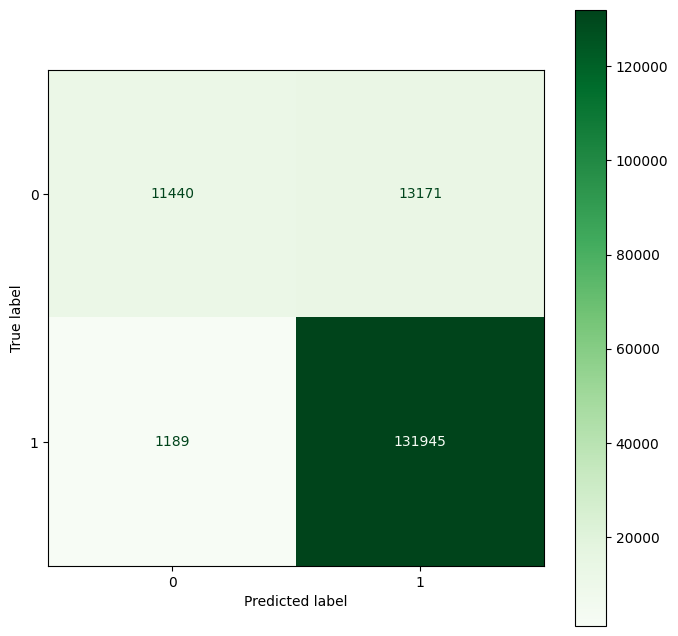

In [34]:
cm = confusion_matrix(y_test,label_predicted)
fig = plt.figure(figsize = (8,8))
axis = fig.add_subplot(1, 1, 1)
cm = metrics.ConfusionMatrixDisplay(cm,display_labels=range(2))
cm.plot(values_format='d', cmap ='Greens',ax =axis)


In [ ]:
'''Random Forest'''
rf_classifier = RandomForestClassifier(class_weight="balanced")
rf_classifier.fit(tfidf_train,y_train)

In [249]:
rf_label_predicted = rf_classifier.predict(tfidf_test)

In [250]:
#Accuracy score for TF-IDF 
rf_tfidf_score = metrics.accuracy_score(y_test,rf_label_predicted)
print("Random Forest TF-IDF accuracy score:", rf_tfidf_score)


Random Forest TF-IDF accuracy score: 0.9375447716250911


In [297]:
rf_tfidf_report = metrics.classification_report(y_test,rf_label_predicted, target_names =['Neg','Pos'])
print(rf_tfidf_report)

              precision    recall  f1-score   support

         Neg       0.95      0.63      0.76     24611
         Pos       0.94      0.99      0.96    133134

    accuracy                           0.94    157745
   macro avg       0.94      0.81      0.86    157745
weighted avg       0.94      0.94      0.93    157745



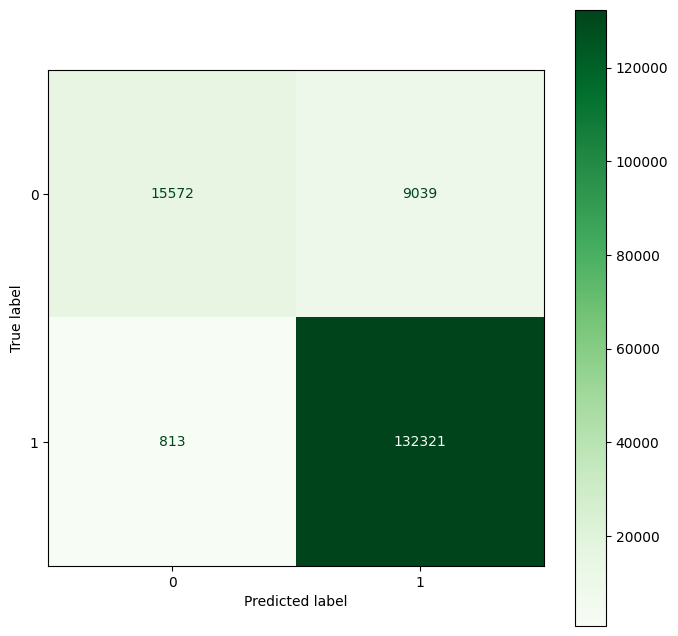

In [252]:
cm_rf = confusion_matrix(y_test,rf_label_predicted)
fig = plt.figure(figsize = (8,8))
axis = fig.add_subplot(1, 1, 1)
cm_rf = metrics.ConfusionMatrixDisplay(cm_rf,display_labels=range(2))
cm_rf.plot(values_format='d', cmap ='Greens',ax =axis)

In [41]:
''' Multinomial Naive Bayes '''
mb_classifier = MultinomialNB()

mb_tfidf = mb_classifier.fit(tfidf_train,y_train)



In [42]:

mb_label_predicted = mb_classifier.predict(tfidf_test)

In [43]:
#Accuracy score for TF-IDF 
mb_tfidf_score = metrics.accuracy_score(y_test,mb_label_predicted)
print("Naive Bayes TF-IDF accuracy score:", mb_tfidf_score)

Naive Bayes TF-IDF accuracy score: 0.8784050207613554


In [44]:
mb_tfidf_report = metrics.classification_report(y_test,mb_label_predicted, target_names =['Neg','Pos'])
print(mb_tfidf_report)

              precision    recall  f1-score   support

         Neg       0.92      0.24      0.38     24611
         Pos       0.88      1.00      0.93    133134

    accuracy                           0.88    157745
   macro avg       0.90      0.62      0.66    157745
weighted avg       0.88      0.88      0.85    157745



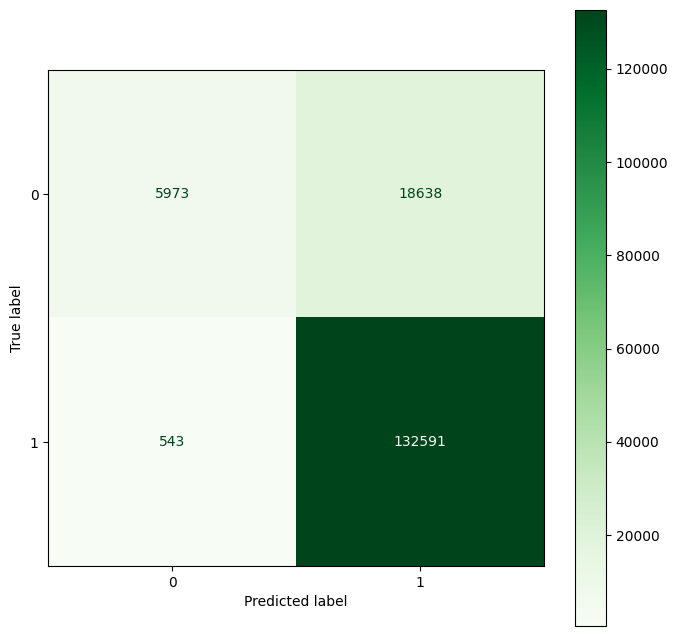

In [295]:
cm_mb = confusion_matrix(y_test,mb_label_predicted)
fig = plt.figure(figsize = (8,8))
axis = fig.add_subplot(1, 1, 1)
cm_mb = metrics.ConfusionMatrixDisplay(cm_mb,display_labels=range(2))
cm_mb.plot(values_format='d', cmap ='Greens',ax =axis)

In [36]:
'''Perceptron'''

perceptron = SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
perceptron.fit(tfidf_train,y_train)

SGDClassifier(eta0=1, learning_rate='constant', loss='perceptron', penalty=None)

In [37]:

p_label_predicted = perceptron.predict(tfidf_test)

In [38]:
#Accuracy score for TF-IDF 
p_tfidf_score = metrics.accuracy_score(y_test,p_label_predicted)
print("Perceptron TF-IDF accuracy score:", p_tfidf_score)

Perceptron TF-IDF accuracy score: 0.8971060889410124


In [39]:
p_tfidf_report = metrics.classification_report(y_test,p_label_predicted, target_names =['Neg','Pos'])
print(p_tfidf_report)

              precision    recall  f1-score   support

         Neg       0.66      0.69      0.68     24611
         Pos       0.94      0.94      0.94    133134

    accuracy                           0.90    157745
   macro avg       0.80      0.81      0.81    157745
weighted avg       0.90      0.90      0.90    157745



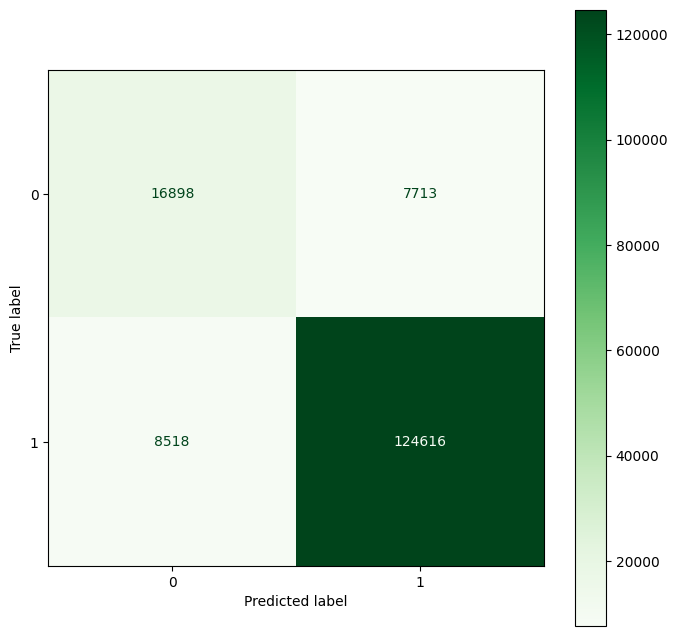

In [40]:
cm_p = confusion_matrix(y_test,p_label_predicted)
fig = plt.figure(figsize = (8,8))
axis = fig.add_subplot(1, 1, 1)
cm_p = metrics.ConfusionMatrixDisplay(cm_p,display_labels=range(2))
cm_p.plot(values_format='d', cmap ='Greens',ax =axis)

Word2vec Model

In [46]:
import gensim
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer 
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [47]:
Data.shape

(525814, 2)

In [48]:
Data.sample(10)

,Sentiment,Text
33917,Negative,"Supposedly increases milk production? Yeah, I ..."
319877,Positive,These roasted coconut chips are absolutely fab...
149898,Positive,BY FAR the best coffee on the market. If the ...
307341,Positive,My sister loved her gift basket and the items ...
407110,Positive,"If your kids can not have milk, this stuff is ..."
390912,Positive,I never really ate Pop-Tarts until I was an ad...
127409,Positive,I am using a Senseo machine so this was a nice...
496388,Positive,I like this product. It is slightly sweet for ...
183669,Negative,I ordered $40 worth of product. When it arriv...
145388,Positive,This is a quick & easy way to make green tea. ...


In [49]:
# Balance the dataset with equal instance of the two classes
data_p = data.loc[data.Sentiment == 'Positive', :][:80000]
data_n = data.loc[data.Sentiment == 'Negative', :][:80000]
df_balanced = pd.concat([data_p,data_n], ignore_index=True)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)


In [50]:
df_balanced.shape

(160000, 2)

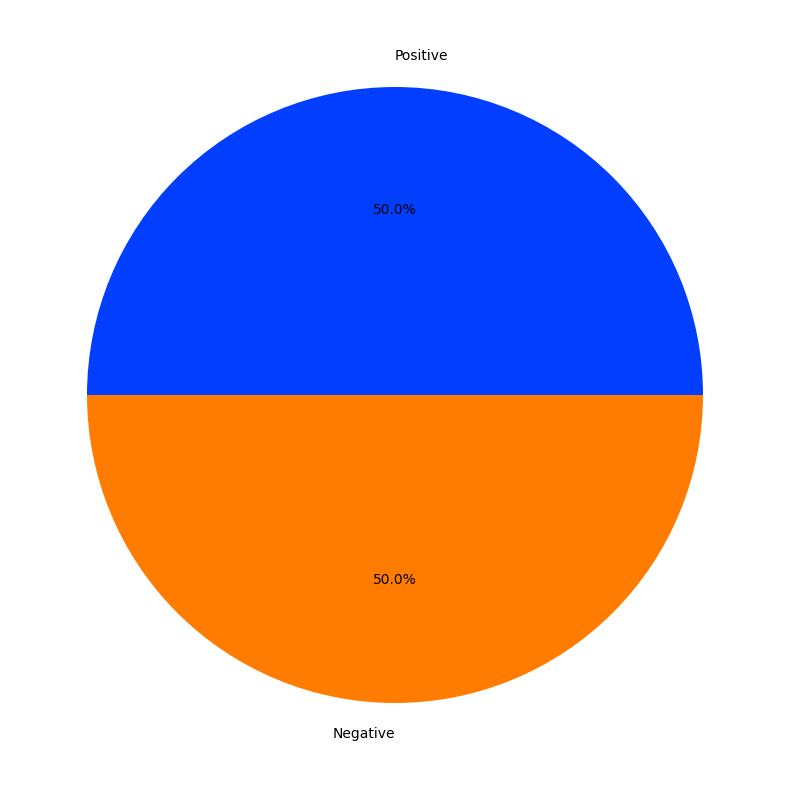

In [51]:
p=0
n=0
for i in df_balanced.Sentiment:
    if i == 'Positive':
        p +=1
    elif i =='Negative':
        n +=1
colors = sns.color_palette('bright')[0:2]
plt.figure(figsize=(10,10))
plt.pie(x = [p,n],labels=['Positive','Negative'],colors=colors,autopct='%1.1f%%')
plt.show()

In [52]:
X_Data = cleanse(df_balanced.Text)
Y_Data = df_balanced.Sentiment


In [53]:
X_Data[0]

'read label experi self great inform locat tea tree cultur around year exist tea leav appeal eye hand aroma bergamot strong yet light appl citrus blend feel like would good season year earl grey tea brew quit nice good strong flavor aroma bergamot remain us enjoy littl longer sinc bergamot oil use help stuffi nose medicin purpos work well southern california spring fall santa ana wind caus much havoc sinus winter flu cold br tin two lid help keep fresh inner lid seem one job first help spill loos tea everywher open outsid lid look like might measur cup use ounc mug tri seem right slight stronger like drank anyway felt rejuven afternoon br thorough enjoy bold smooth flavor tea look forward tri blend rishi tea line product'

In [54]:
Sentences = []
for text in X_Data:
    Sentences.append([i for i in re.split(r' ',text)])
    

In [55]:
w2v_model = gensim.models.Word2Vec(sentences=Sentences,window=10,min_count=1)

In [56]:
w2v_model.train(Sentences,epochs=10,total_examples=len(Sentences))

(60537447, 67448420)

In [57]:
# See the embedding of words
word_embedding = w2v_model.wv.get_vector('king')
print(word_embedding)

[-2.2176392  -0.3422403  -1.4463339  -0.79298335  1.8207978  -0.9992704
  0.35074976  2.352861    0.4335487   1.2017887  -2.2834492  -3.06415
 -0.3244619   1.2668176   2.2177842  -0.5803741  -0.70532787 -0.09799053
 -2.2935197  -1.492999    2.031877    0.85202724  0.20217368  0.11829786
 -0.68756187 -0.43937767  0.39714003  1.5852408  -0.8510816  -0.00729414
 -3.176066   -0.11660335  0.78122425 -1.198095    0.5094672   2.0247371
 -1.3665656   0.18215226 -0.58345824 -4.251073    0.06288852 -0.80944145
  0.92473596 -2.0414221   1.1981919  -0.48757318  0.15135711 -0.51522416
  1.5183651   1.7557555   0.40868455 -0.03446081  0.05632395  2.761491
 -0.34376833 -0.6812264   0.33492658 -0.21624406 -1.9810427  -1.0543034
 -0.13916007  1.2383718  -0.93443716 -0.1516456  -0.71030587  2.3273013
 -0.4983514   0.42990223 -3.398083   -0.02577131 -1.7107079  -0.4339947
  3.7228394  -0.7320024   2.471388   -0.41429457 -0.47497177 -1.6733598
  1.2325361  -1.0528407  -4.2321763   1.4848971  -1.8450583  -

In [58]:
#shape of that word
# shape should the same for all the words
word_embedding.shape

(100,)

In [59]:
# total number of words in the dictionary
len(w2v_model.wv)


44655

In [60]:
# 10  Words similar to a particular word
w2v_model.wv.most_similar(positive=['king'],topn=20)

[('charl', 0.7569440007209778),
 ('cavali', 0.7194687128067017),
 ('oscar', 0.6404210925102234),
 ('presentacion', 0.6068159341812134),
 ('arthur', 0.6042893528938293),
 ('filippo', 0.598175585269928),
 ('elodi', 0.597862184047699),
 ('pequena', 0.5970569849014282),
 ('compacta', 0.5958834886550903),
 ('ransom', 0.5951868891716003),
 ('caja', 0.5926084518432617),
 ('kamehameha', 0.5898286700248718),
 ('muy', 0.5887267589569092),
 ('marqu', 0.5873022079467773),
 ('cavili', 0.5857935547828674),
 ('mongut', 0.5832653641700745),
 ('rajastan', 0.5823112726211548),
 ('buena', 0.5819000601768494),
 ('buen', 0.5785009860992432),
 ('xv', 0.5739405751228333)]

In [61]:
# Make feature vector
# different transformation and fiting techniques
def features(model,sentence,num_features):
    feature_vec  = np.zeros((num_features,),dtype="float32")
    word_dict = set(model.index_to_key) 
    count =1
    for word in sentence:
        if word in word_dict: 
            feature_vec = np.add(feature_vec,model[word])

    feature_vec = np.abs(np.divide(feature_vec, count))
    count+=1
    return feature_vec


# feature: transforming vectore to std_deviation of the vector
def features2(model,sentence,num_features):
    feature_vec  = np.zeros((num_features,),dtype="float32")
    for word in sentence:
            feature_vec = np.std(model[word])
    return feature_vec


In [62]:
# Split the dataset
X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(Sentences,Y_Data,train_size=0.7,stratify=Y_Data,random_state=19)

In [63]:
# fit the dataset
num_features = 100  # default from word2vec

def fit_data(x_set):
    feature_set = np.zeros((len(x_set),num_features), dtype='float32')
    for idx, x in enumerate(x_set):
        feature_set[idx] = features(w2v_model.wv,x,num_features)
    return feature_set



In [64]:
w2v_train = fit_data(X_train_wv)
w2v_test = fit_data(X_test_wv)


print('Word2vec Train:' ,w2v_train.shape)
print('Word2vec Test:' ,w2v_test.shape)

Word2vec Train: (112000, 100)
Word2vec Test: (48000, 100)


In [65]:
'''Linear SVM'''
Svm = SGDClassifier(loss = "hinge", penalty="l2")  # hinge loss gives linear SVM
Svm.fit(w2v_train,y_train_wv)

SGDClassifier()

In [66]:
Svm_w2v_predicted = Svm.predict(w2v_test)

In [67]:
Svm_w2v_score = metrics.accuracy_score(y_test_wv, Svm_w2v_predicted)
print("Linear SVM accuracy score:", Svm_w2v_score)

Linear SVM accuracy score: 0.686375


In [68]:
Svm_w2v_report = metrics.classification_report(y_test_wv,Svm_w2v_predicted, target_names =['Neg','Pos'])
print(Svm_w2v_report)

              precision    recall  f1-score   support

         Neg       0.63      0.88      0.74     24000
         Pos       0.81      0.49      0.61     24000

    accuracy                           0.69     48000
   macro avg       0.72      0.69      0.67     48000
weighted avg       0.72      0.69      0.67     48000



In [69]:
'''Random Forest Classifier'''
Rf = RandomForestClassifier(n_estimators = 100)
Rf_w2v = Rf.fit(w2v_train,y_train_wv)

In [70]:
Rf_w2v_predicted = Rf.predict(w2v_test)

In [71]:
Rf_w2v_score = metrics.accuracy_score(y_test_wv, Rf_w2v_predicted)
print("Random Forest Classifier accuracy score:", Rf_w2v_score)

Random Forest Classifier accuracy score: 0.8336666666666667


In [86]:
Rf_w2v_report = metrics.classification_report(y_test_wv,Rf_w2v_predicted, target_names =['Neg','Pos'])
print(Rf_w2v_report)

              precision    recall  f1-score   support

         Neg       0.84      0.80      0.82     24000
         Pos       0.81      0.85      0.83     24000

    accuracy                           0.83     48000
   macro avg       0.83      0.83      0.83     48000
weighted avg       0.83      0.83      0.83     48000



In [72]:
'''Multinomial Naive Bayes Classifier'''
Mb = MultinomialNB()
Mb_w2v = Mb.fit(w2v_train,y_train_wv)

In [73]:
Mb_w2v_predicted = Mb.predict(w2v_test)

In [74]:
Mb_w2v_score = metrics.accuracy_score(y_test_wv, Mb_w2v_predicted)
print("Naive Bayes Classifier accuracy score:", Mb_w2v_score)

Naive Bayes Classifier accuracy score: 0.7264583333333333


In [75]:
Mb_w2v_report = metrics.classification_report(y_test_wv,Mb_w2v_predicted, target_names =['Neg','Pos'])
print(Mb_w2v_report)

              precision    recall  f1-score   support

         Neg       0.73      0.71      0.72     24000
         Pos       0.72      0.74      0.73     24000

    accuracy                           0.73     48000
   macro avg       0.73      0.73      0.73     48000
weighted avg       0.73      0.73      0.73     48000



In [78]:
'''Perceptron'''

Perceptron = SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
Perceptron.fit(w2v_train,y_train_wv)

SGDClassifier(eta0=1, learning_rate='constant', loss='perceptron', penalty=None)

In [79]:
P_w2v_predicted = Perceptron.predict(w2v_test)

In [80]:
P_w2v_score = metrics.accuracy_score(y_test_wv, P_w2v_predicted)
print("Perceptron accuracy score:", P_w2v_score)

Perceptron accuracy score: 0.7012708333333333


In [81]:
P_w2v_report = metrics.classification_report(y_test_wv,P_w2v_predicted, target_names =['Neg','Pos'])
print(P_w2v_report)

              precision    recall  f1-score   support

         Neg       0.66      0.82      0.73     24000
         Pos       0.76      0.59      0.66     24000

    accuracy                           0.70     48000
   macro avg       0.71      0.70      0.70     48000
weighted avg       0.71      0.70      0.70     48000



Pretrained BERT model without fine tuning

In [82]:
import numpy as np
import pandas as pd
import nltk
from transformers import pipeline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

2022-11-02 20:51:58.690244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 20:51:58.880990: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-02 20:51:58.950711: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 20:51:59.573665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [83]:
df = pd.read_csv('./Data/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [84]:
for ct,i in enumerate(df['Score']):
    if i >3:
        df.Score[ct] = 'POSITIVE'
    elif i<3:
        df.Score[ct] = 'NEGATIVE'
    else:
        df.Score[ct] = 'NEUTRAL'


/tmp/ipykernel_11187/1176667006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Score[ct] = 'POSITIVE'


In [85]:
data = df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Time','Summary'],axis=1)
rnm_dict = {'Score':'Sentiment', 'Text':'Text'}
data.rename(columns=rnm_dict, inplace=True)
data.head()

,Sentiment,Text
0,POSITIVE,I have bought several of the Vitality canned d...
1,NEGATIVE,Product arrived labeled as Jumbo Salted Peanut...
2,POSITIVE,This is a confection that has been around a fe...
3,NEGATIVE,If you are looking for the secret ingredient i...
4,POSITIVE,Great taffy at a great price. There was a wid...


In [86]:
# drop neutral, classify as either positive or negative review
neutral = data[data['Sentiment']=='NEUTRAL']
index_of_neutral =neutral.index
data.drop(index_of_neutral, inplace=True)

In [87]:
# Split the dataset into training and Validation set
def split_dataset(dat,ratio):
    train_set = dat.sample(frac = ratio, random_state=200)
    validation_set = dat.drop(train_set.index)
    return train_set, validation_set
train, val = split_dataset(data,0.7) 

In [88]:
val

,Sentiment,Text
0,POSITIVE,I have bought several of the Vitality canned d...
2,POSITIVE,This is a confection that has been around a fe...
8,POSITIVE,Right now I'm mostly just sprouting this so my...
9,POSITIVE,This is a very healthy dog food. Good for thei...
13,POSITIVE,good flavor! these came securely packed... the...
...,...,...
568424,POSITIVE,I've tried several violet flavored candies in ...
568443,POSITIVE,I love this tea. I first discovered the pleas...
568446,NEGATIVE,I had ordered some of these a few months back ...
568450,NEGATIVE,I'm disappointed with the flavor. The chocolat...


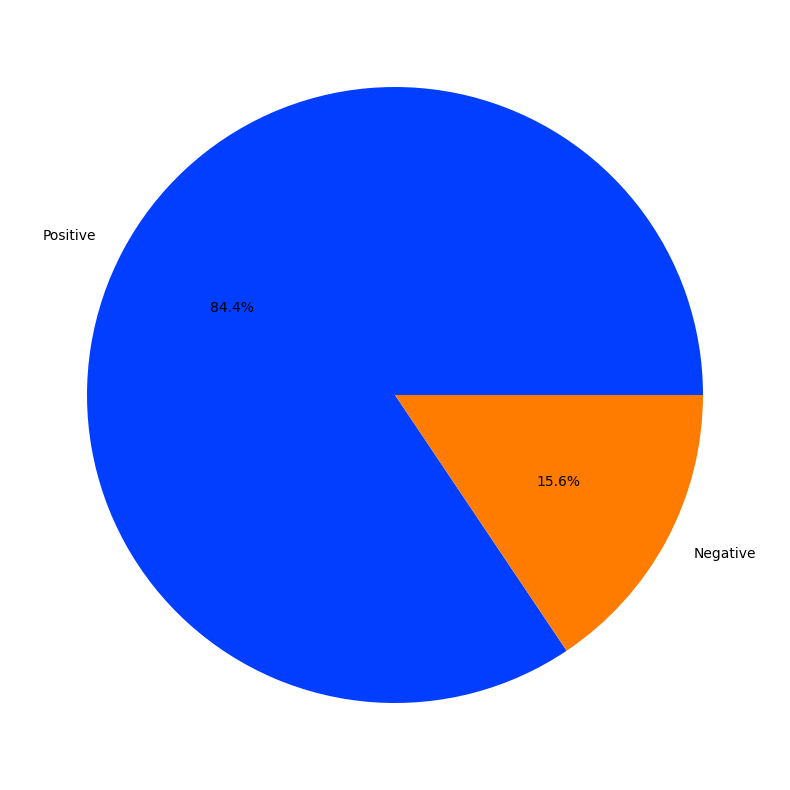

In [89]:

P=0
N=0
for i in val['Sentiment']:
    if i == 'POSITIVE':
        P +=1
    elif i =='NEGATIVE':
        N +=1
colors = sns.color_palette('bright')[0:2]
plt.figure(figsize=(10,10))
plt.pie(x = [P,N],labels=['Positive','Negative'],colors=colors,autopct='%1.1f%%')
plt.show()


In [90]:
# balancve the dataset
num =int(0.15 *len(val))
print("Number of datapoints: ",num)
# Balance the dataset with equal instance of the two classes
data_p = data.loc[data.Sentiment == 'POSITIVE', :][:num]
data_n = data.loc[data.Sentiment == 'NEGATIVE', :][:num]
val_balanced = pd.concat([data_p,data_n], ignore_index=True)
val_balanced = val_balanced.sample(frac=1).reset_index(drop=True)

Number of datapoints:  23661


In [91]:
sentiment_classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [92]:
bert_predicted = []
for sentence in val_balanced['Text']:
    predicted_label = sentiment_classifier(sentence,max_length=30,truncation =True)[0]['label']
    bert_predicted.append(predicted_label)

In [93]:
ground_truth = []
for y in val_balanced['Sentiment']:
    ground_truth.append(y)

In [94]:
bert_score = metrics.accuracy_score(ground_truth, bert_predicted)
print("BERT pretrained model classfication accuracy score:", bert_score)

BERT pretrained model classfication accuracy score: 0.7400363467309073


In [95]:
bert_report = metrics.classification_report(ground_truth,bert_predicted, target_names =['Neg','Pos'])
print(bert_report)

              precision    recall  f1-score   support

         Neg       0.73      0.75      0.74     23661
         Pos       0.75      0.73      0.74     23661

    accuracy                           0.74     47322
   macro avg       0.74      0.74      0.74     47322
weighted avg       0.74      0.74      0.74     47322



Fine tuning BERT model

In [96]:
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import pandas as pd
import numpy as np
from transformers import BertModel
from transformers import BertTokenizer
from torch.utils.data.dataloader import default_collate

In [97]:
'''Fine tuning BERT'''

def preprocess_data(df):
    for ct,i in enumerate(df['Score']):
        if i >3:
            df.loc[ct,('Score')] = 1
        elif i<3:
            df.loc[ct,('Score')] = 0
        else:
            df.loc[ct,('Score')] = 'NEUTRAL'

    data = df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Time','Summary'],axis=1)
    rnm_dict = {'Score':'Sentiment', 'Text':'Text'}
    data.rename(columns=rnm_dict, inplace=True)
    neutral = data[data['Sentiment']=='NEUTRAL']
    index_of_neutral =neutral.index
    data.drop(index_of_neutral, inplace=True)
    return data


def split_dataset(df,train_percent = 0.7):
    #train_len = int(train_percent * df.shape[0])
    train_set = df.iloc[:10000]
    test_set = df.iloc[10001:20000]
    return train_set, test_set

data = pd.read_csv('./Data/Reviews.csv')

dat = preprocess_data(data)
print(dat.shape[0])
 
training_set,testing_set = split_dataset(dat)

print(training_set.shape[0])

525814
10000


In [98]:
# Train on GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl.to_torch
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [99]:
device = get_default_device()
print(device)


cuda


In [100]:
class ReviewDataset(Dataset):
    # custom build dataset
    def __init__(self,tokenizer, max_length):
        super(ReviewDataset,self).__init__()
        self.tokenizer = tokenizer
        #data loading
        df = training_set
        self.X = df.Text.to_numpy()
        self.y = df.Sentiment.to_numpy()
        self.num_samples = df.shape[0]
        self.max_length = max_length

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        input = self.tokenizer.encode_plus( self.X[index], max_length=self.max_length, pad_to_max_length=True, add_special_tokens=True, return_attention_mask=True)
        ids = input["input_ids"]
        token_type_ids = input["token_type_ids"]
        mask = input["attention_mask"]

        return {'ids': torch.tensor(ids,dtype=torch.long),'mask': torch.tensor(mask, dtype=torch.long), 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.y[index], dtype=torch.long)}
    
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
data_set = ReviewDataset(tokenizer, max_length=100)
dataloader = DataLoader(dataset= data_set, batch_size=32, shuffle=True, pin_memory=True)
#dataloader = DeviceDataLoader(dataloader,device)

In [101]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert_model =  BertModel.from_pretrained('bert-base-uncased')
        self.out = nn.Linear(768,1)

    def forward(self,ids, mask, token_type_ids):
        _, x = self.bert_model(ids,attention_mask = mask,token_type_ids=token_type_ids, return_dict=False)

        out = self.out(x)
        return out

model =BERT()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [102]:
# @torch.no_grad()
for param in model.bert_model.parameters():
    param.requires_grad = False

In [103]:
def finetune(epochs,dataloader,model,loss_fn,optimizer):
    
    model.train()
    for  epoch in tqdm(range(epochs)):
        print("Number of epochs: ",epoch)
        
        loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
        for batch, dl in loop:
            ids=dl['ids']
            token_type_ids=dl['token_type_ids']
            mask= dl['mask']
            label=dl['target']
            label = label.unsqueeze(1)
            
            optimizer.zero_grad()
            
            output=model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids)
            label = label.type_as(output)

            loss=loss_fn(output,label)
            loss.backward()
            
            optimizer.step()
            
            pred = np.where(output >= 0, 1, 0)

            num_correct = sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            num_samples = pred.shape[0]
            accuracy = num_correct/num_samples
            
            print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
            
            # Show progress while training
            loop.set_description(f'Epoch={epoch}/{epochs}')
            loop.set_postfix(loss=loss.item(),acc=accuracy)

    return model

In [104]:

model=finetune(5, dataloader, model, loss_fn, optimizer)
torch.save(model,'./Model/model.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Number of epochs:  0


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/thabsheerjm/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Got 4 / 32 with accuracy 12.50


Got 9 / 32 with accuracy 28.12


Got 12 / 32 with accuracy 37.50


Got 13 / 32 with accuracy 40.62


Got 10 / 32 with accuracy 31.25


Got 20 / 32 with accuracy 62.50


Got 20 / 32 with accuracy 62.50


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 31 / 32 with accuracy 96.88


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 22 / 32 with accuracy 68.75


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 32 / 32 with accuracy 100.00


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 22 / 32 with accuracy 68.75


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 22 / 32 with accuracy 68.75


Got 22 / 32 with accuracy 68.75


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 21 / 32 with accuracy 65.62


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 31 / 32 with accuracy 96.88


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 23 / 32 with accuracy 71.88


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 19 / 32 with accuracy 59.38


Got 22 / 32 with accuracy 68.75


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


 20%|██        | 1/5 [05:24<21:36, 324.03s/it]

Got 14 / 16 with accuracy 87.50
Number of epochs:  1


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 31 / 32 with accuracy 96.88


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 31 / 32 with accuracy 96.88


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 32 / 32 with accuracy 100.00


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 31 / 32 with accuracy 96.88


Got 28 / 32 with accuracy 87.50


Got 22 / 32 with accuracy 68.75


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 30 / 32 with accuracy 93.75


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 19 / 32 with accuracy 59.38


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 31 / 32 with accuracy 96.88


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 31 / 32 with accuracy 96.88


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 31 / 32 with accuracy 96.88


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 31 / 32 with accuracy 96.88


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 22 / 32 with accuracy 68.75


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 24 / 32 with accuracy 75.00


 40%|████      | 2/5 [10:48<16:13, 324.36s/it]

Got 16 / 16 with accuracy 100.00
Number of epochs:  2


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 22 / 32 with accuracy 68.75


Got 24 / 32 with accuracy 75.00


Got 20 / 32 with accuracy 62.50


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 23 / 32 with accuracy 71.88


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 20 / 32 with accuracy 62.50


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 22 / 32 with accuracy 68.75


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 31 / 32 with accuracy 96.88


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 22 / 32 with accuracy 68.75


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 21 / 32 with accuracy 65.62


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 22 / 32 with accuracy 68.75


Got 26 / 32 with accuracy 81.25


Got 20 / 32 with accuracy 62.50


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


 60%|██████    | 3/5 [16:14<10:49, 324.91s/it]

Got 12 / 16 with accuracy 75.00
Number of epochs:  3


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 22 / 32 with accuracy 68.75


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 24 / 32 with accuracy 75.00


Got 31 / 32 with accuracy 96.88


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 22 / 32 with accuracy 68.75


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 21 / 32 with accuracy 65.62


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 22 / 32 with accuracy 68.75


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 32 / 32 with accuracy 100.00


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 23 / 32 with accuracy 71.88


Got 31 / 32 with accuracy 96.88


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 23 / 32 with accuracy 71.88


Got 31 / 32 with accuracy 96.88


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 23 / 32 with accuracy 71.88


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 22 / 32 with accuracy 68.75


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 20 / 32 with accuracy 62.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 21 / 32 with accuracy 65.62


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 31 / 32 with accuracy 96.88


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 27 / 32 with accuracy 84.38


Got 19 / 32 with accuracy 59.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 20 / 32 with accuracy 62.50


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 31 / 32 with accuracy 96.88


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 32 / 32 with accuracy 100.00


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


 80%|████████  | 4/5 [21:43<05:26, 326.50s/it]

Got 14 / 16 with accuracy 87.50
Number of epochs:  4


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 22 / 32 with accuracy 68.75


Got 30 / 32 with accuracy 93.75


Got 31 / 32 with accuracy 96.88


Got 27 / 32 with accuracy 84.38


Got 22 / 32 with accuracy 68.75


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 21 / 32 with accuracy 65.62


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 23 / 32 with accuracy 71.88


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 22 / 32 with accuracy 68.75


Got 23 / 32 with accuracy 71.88


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 31 / 32 with accuracy 96.88


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 32 / 32 with accuracy 100.00


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 31 / 32 with accuracy 96.88


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 24 / 32 with accuracy 75.00


Got 23 / 32 with accuracy 71.88


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 30 / 32 with accuracy 93.75


Got 23 / 32 with accuracy 71.88


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 22 / 32 with accuracy 68.75


Got 21 / 32 with accuracy 65.62


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 28 / 32 with accuracy 87.50


Got 29 / 32 with accuracy 90.62


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 32 / 32 with accuracy 100.00


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 24 / 32 with accuracy 75.00


Got 23 / 32 with accuracy 71.88


Got 25 / 32 with accuracy 78.12


Got 22 / 32 with accuracy 68.75


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 28 / 32 with accuracy 87.50


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 27 / 32 with accuracy 84.38


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 30 / 32 with accuracy 93.75


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 30 / 32 with accuracy 93.75


Got 26 / 32 with accuracy 81.25


Got 28 / 32 with accuracy 87.50


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 31 / 32 with accuracy 96.88


Got 29 / 32 with accuracy 90.62


Got 23 / 32 with accuracy 71.88


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 29 / 32 with accuracy 90.62


Got 25 / 32 with accuracy 78.12


Got 24 / 32 with accuracy 75.00


Got 28 / 32 with accuracy 87.50


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 24 / 32 with accuracy 75.00


Got 25 / 32 with accuracy 78.12


Got 27 / 32 with accuracy 84.38


Got 24 / 32 with accuracy 75.00


Got 29 / 32 with accuracy 90.62


Got 27 / 32 with accuracy 84.38


Got 26 / 32 with accuracy 81.25


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 29 / 32 with accuracy 90.62


Got 26 / 32 with accuracy 81.25


Got 27 / 32 with accuracy 84.38


Got 25 / 32 with accuracy 78.12


Got 23 / 32 with accuracy 71.88


Got 22 / 32 with accuracy 68.75


Got 26 / 32 with accuracy 81.25


Got 25 / 32 with accuracy 78.12


100%|██████████| 5/5 [27:09<00:00, 325.95s/it]

Got 15 / 16 with accuracy 93.75


In [105]:

trained_model = torch.load('./Model/model.pth')
trained_model.eval()

BERT(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [106]:
#test set
class valDataset(Dataset):
    # custom build dataset
    def __init__(self,tokenizer, max_length):
        super(valDataset,self).__init__()
        self.tokenizer = tokenizer
        #data loading
        df = testing_set
        self.X = df.Text.to_numpy()
        self.y = df.Sentiment.to_numpy()
        self.num_samples = df.shape[0]
        self.max_length = max_length

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        input = self.tokenizer.encode_plus( self.X[index], max_length=self.max_length, pad_to_max_length=True, add_special_tokens=True, return_attention_mask=True)
        ids = input["input_ids"]
        token_type_ids = input["token_type_ids"]
        mask = input["attention_mask"]

        return {'ids': torch.tensor(ids,dtype=torch.long),'mask': torch.tensor(mask, dtype=torch.long), 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.y[index], dtype=torch.long)}
    
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
dset = valDataset(tokenizer, max_length=100)

In [ ]:

print(lb[0])
Lb = []
for i in lb:
    print(i)
    for j in i:
        value = np.array(i)[0]
        print(value)
        #Lb.extend(value)

#print(Lb)
# from sklearn import metrics
# bert_report =  metrics.classification_report(gt,lb)